### This notebook will be used for hyperperameter tuning, feature selection, and final modeling

In [1]:
#Python packages
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 400)
import re
from scipy import stats

#Visualization packages
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#ML modeling packages
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')
import gc

In [9]:
# X_train = pd.read_pickle('train_encoded.pkl')
X_train = pd.read_pickle('train_mod2.pkl')
print(X_train.shape)

(19869886, 31)


In [3]:
X_train.head()

,building_id,site_id,meter,primary_use,meter_reading,square_feet,year_built,floor_count,hour,weekday,month,day,is_holiday,air_temperature,cloud_coverage,feels,wind_chill,heat_index,radiation,altitude,solar_spec,hour_roc,month_roc,dew_temperature,sea_level_pressure,wind_direction,wind_speed,air_temperature_mean_lag72,dew_temperature_mean_lag72,sea_level_pressure_mean_lag72,wind_direction_mean_lag72,wind_speed_mean_lag72,air_temperature_mean_lag3,dew_temperature_mean_lag3,sea_level_pressure_mean_lag3
103,105,1,0,Education,23.303600,50623.0,-999.0,5.0,0.0,1.0,1.0,1.0,1.0,3.800781,-999.0,33.779079,33.78125,34.131039,1414.0,-64.1875,-999.0,0.304688,3.40625,2.400391,1021.0,240.0,3.099609,12.289062,9.625000,1022.5,0.0,0.0,13.296875,11.101562,1023.0
104,106,1,0,Education,0.374600,5374.0,-999.0,4.0,0.0,1.0,1.0,1.0,1.0,3.800781,-999.0,33.779079,33.78125,34.131039,1414.0,-64.1875,-999.0,0.304688,3.40625,2.400391,1021.0,240.0,3.099609,12.304688,9.648438,1022.5,0.0,0.0,13.296875,11.101562,1023.0
105,106,1,3,Education,0.000000,5374.0,-999.0,4.0,0.0,1.0,1.0,1.0,1.0,3.800781,-999.0,33.779079,33.78125,34.131039,1414.0,-64.1875,-999.0,0.304688,3.40625,2.400391,1021.0,240.0,3.099609,12.320312,9.671875,1022.5,0.0,0.0,13.296875,11.101562,1023.0
106,107,1,0,Education,175.184006,97532.0,2005.0,10.0,0.0,1.0,1.0,1.0,1.0,3.800781,-999.0,33.779079,33.78125,34.131039,1414.0,-64.1875,-999.0,0.304688,3.40625,2.400391,1021.0,240.0,3.099609,12.335938,9.695312,1022.5,0.0,0.0,13.296875,11.101562,1023.0
107,108,1,0,Education,91.265297,81580.0,1913.0,5.0,0.0,1.0,1.0,1.0,1.0,3.800781,-999.0,33.779079,33.78125,34.131039,1414.0,-64.1875,-999.0,0.304688,3.40625,2.400391,1021.0,240.0,3.099609,12.351562,9.718750,1022.5,0.0,0.0,13.296875,11.101562,1023.0


In [6]:
# X_train.drop(['air_temperature_mean_lag72','air_temperature_mean_lag3','wind_direction_mean_lag72',
#              'wind_speed_mean_lag3', 'precip_depth_1_hr_mean_lag72','month', 'day', 'solar_spec', 
#              'air_temperature_max_lag72', 'air_temperature_min_lag72', 'wind_speed_mean_lag72'], axis=1, inplace=True)

In [3]:
y_train = np.log1p(X_train["meter_reading"])
X_train.drop('meter_reading', axis=1,inplace=True)
gc.collect()

62

### CV & Modeling

In [6]:
# declare target, categorical and numeric columns
target = 'meter_reading'
categorical = ['building_id', 'site_id', 'primary_use', 'meter']
numeric_cols = [col for col in X_train.columns if col not in categorical + [target, 'year','day ', 'month']]
features = categorical + numeric_cols

In [5]:
from sklearn.utils.multiclass import type_of_target

type_of_target(y_train)

'continuous'

In [5]:
X_train.columns

Index(['building_id', 'site_id', 'meter', 'primary_use', 'square_feet',
       'year_built', 'floor_count', 'hour', 'weekday', 'month', 'day',
       'is_holiday', 'air_temperature', 'cloud_coverage', 'feels',
       'wind_chill', 'heat_index', 'radiation', 'altitude', 'solar_spec',
       'hour_roc', 'month_roc', 'dew_temperature', 'sea_level_pressure',
       'wind_direction', 'wind_speed', 'air_temperature_mean_lag72',
       'dew_temperature_mean_lag72', 'sea_level_pressure_mean_lag72',
       'wind_direction_mean_lag72', 'wind_speed_mean_lag72',
       'air_temperature_mean_lag3', 'dew_temperature_mean_lag3',
       'sea_level_pressure_mean_lag3'],
      dtype='object')

## 2-Fold Split

In [5]:
import lightgbm as lgb ##https://www.kaggle.com/roydatascience/ashrae-stratified-kfold-lightgbm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm import tqdm_notebook as tqdm
import os
import gc


X_half_1 = X_train[:int(X_train.shape[0] / 2)]
X_half_2 = X_train[int(X_train.shape[0] / 2):]

y_half_1 = y_train[:int(X_train.shape[0] / 2)]
y_half_2 = y_train[int(X_train.shape[0] / 2):]

categorical_features = ["building_id", "site_id", "hour", 'primary_use','month', 'is_holiday']

d_half_1 = lgb.Dataset(X_half_1, label=y_half_1, categorical_feature=categorical_features, free_raw_data=False)
d_half_2 = lgb.Dataset(X_half_2, label=y_half_2, categorical_feature=categorical_features, free_raw_data=False)

watchlist_1 = [d_half_1, d_half_2]
watchlist_2 = [d_half_2, d_half_1]

params =  {'num_leaves': 1580,
         'objective': 'regression',
         'learning_rate': 0.05,
         'boosting': 'gbdt',
         'subsample': 0.4,
         'feature_fraction': 0.7,
         'n_jobs': -1,
         'seed': 50,
         'metric': 'rmse'
          }

print("Building model with first half and validating on second half:")
model_half_1 = lgb.train(params, train_set=d_half_1, num_boost_round=1000, valid_sets=watchlist_1, verbose_eval=200, early_stopping_rounds=200)

print("Building model with second half and validating on first half:")
model_half_2 = lgb.train(params, train_set=d_half_2, num_boost_round=1000, valid_sets=watchlist_2, verbose_eval=200, early_stopping_rounds=200)

gc.collect()

Building model with first half and validating on second half:
Training until validation scores don't improve for 200 rounds
[200]	training's rmse: 0.499	valid_1's rmse: 1.2642
Early stopping, best iteration is:
[81]	training's rmse: 0.620403	valid_1's rmse: 1.24467
Building model with second half and validating on first half:
Training until validation scores don't improve for 200 rounds
[200]	training's rmse: 0.508372	valid_1's rmse: 1.18465
Early stopping, best iteration is:
[81]	training's rmse: 0.628997	valid_1's rmse: 1.16882


342

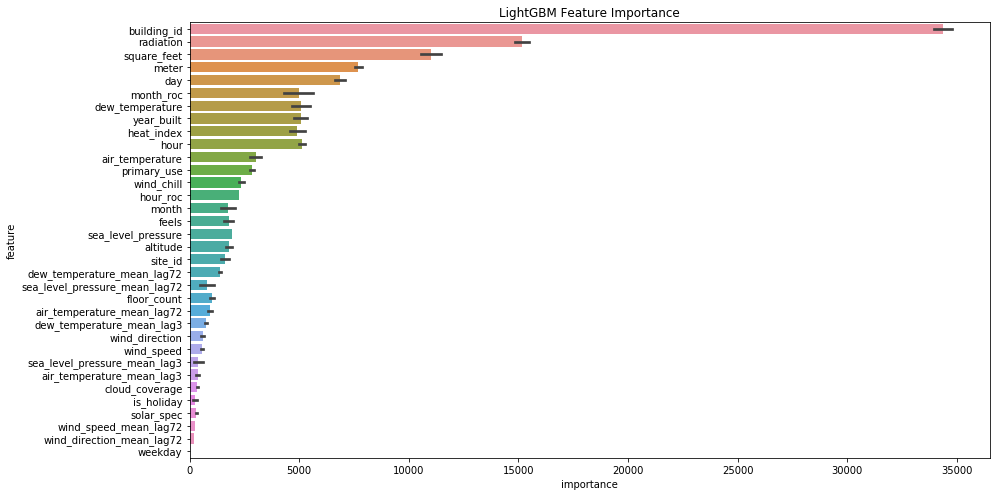

In [8]:
df_fimp_1 = pd.DataFrame()
df_fimp_1["feature"] = X_train.columns.values
df_fimp_1["importance"] = model_half_1.feature_importance()
df_fimp_1["half"] = 1

df_fimp_2 = pd.DataFrame()
df_fimp_2["feature"] = X_train.columns.values
df_fimp_2["importance"] = model_half_2.feature_importance()
df_fimp_2["half"] = 2

df_fimp = pd.concat([df_fimp_1, df_fimp_2], axis=0)

plt.figure(figsize=(14, 7))
sns.barplot(x="importance", y="feature", data=df_fimp.sort_values(by="importance", ascending=False))
plt.title("LightGBM Feature Importance")
plt.tight_layout()

In [3]:
# X_train.drop(['air_temperature_std_lag72','x0_Warehouse/storage', 'x0_Religious worship',
#              'cloud_coverage_mean_lag72','x0_Utility','x0_Parking','x0_Other','x0_Services',
#              'x0_Food sales and service','air_temperature_max_lag3'],axis=1,inplace=True)
# gc.collect()

62

### 2-Fold Prediction

In [3]:
# test = pd.read_pickle('test_encoded.pkl')
test = pd.read_pickle('test_mod2.pkl')
test.shape
gc.collect()

35

In [5]:
# sub = pd.read_csv('submission.csv', index_col=0)

In [3]:
# test.drop(['air_temperature_mean_lag72','air_temperature_mean_lag3','wind_direction_mean_lag72',
#              'wind_speed_mean_lag3', 'precip_depth_1_hr_mean_lag72','month', 'day', 'solar_spec', 
#              'air_temperature_max_lag72', 'air_temperature_min_lag72', 'wind_speed_mean_lag72'], axis=1, inplace=True)

In [4]:
# test.drop(['air_temperature_std_lag72','x0_Warehouse/storage', 'x0_Religious worship',
#              'cloud_coverage_mean_lag72','x0_Utility','x0_Parking','x0_Other','x0_Services',
#              'x0_Food sales and service', 'air_temperature_max_lag3'],axis=1,inplace=True)
# gc.collect()

66

In [7]:
pred = np.expm1(model_half_1.predict(test, num_iteration=model_half_1.best_iteration)) / 2

del model_half_1
gc.collect()

pred += np.expm1(model_half_2.predict(test, num_iteration=model_half_2.best_iteration)) / 2
    
del model_half_2
gc.collect()

25

In [8]:
submission = pd.DataFrame({'row_id':range(0,len(test)), "meter_reading": np.clip(pred, 0, a_max=None)})
submission.to_csv("submission.csv", index=False)

In [9]:
submission.head()

,row_id,meter_reading
0,0,91.977792
1,1,54.447551
2,2,11.434571
3,3,129.405502
4,4,465.785010


In [ ]:
####first true score 1.128. remember to ensemble this feature

## 5-Fold Stratified

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

import lightgbm as lgb 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm import tqdm_notebook as tqdm
import os

In [4]:
target = np.log1p(X_train["meter_reading"])
X_train.drop('meter_reading', axis=1,inplace=True)
gc.collect()

38

In [5]:
categorical_features = ["building_id", "site_id", "meter", "hour", 'primary_use']
features = [col for col in X_train.columns if col not in ['month']]
params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 1580,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 1,
    "metric": "rmse",
}

kf = StratifiedKFold(n_splits=5, shuffle=False, random_state=2319)
models = []
for train_index,test_index in kf.split(X_train, X_train['month']):
    train_features = X_train[features].loc[train_index]
    train_target = target.loc[train_index]
    
    test_features = X_train[features].loc[test_index]
    test_target = target.loc[test_index]
    
    d_training = lgb.Dataset(train_features, label=train_target,categorical_feature=categorical_features, free_raw_data=False)
    d_test = lgb.Dataset(test_features, label=test_target,categorical_feature=categorical_features, free_raw_data=False)
    
    model = lgb.train(params, train_set=d_training, num_boost_round=3000, valid_sets=[d_training,d_test], verbose_eval=25, early_stopping_rounds=50)
    models.append(model)
    del train_features, train_target, test_features, test_target, d_training, d_test
    gc.collect()

Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.03618	valid_1's rmse: 1.08948
[50]	training's rmse: 0.777327	valid_1's rmse: 0.884737
[75]	training's rmse: 0.691578	valid_1's rmse: 0.845749
[100]	training's rmse: 0.640564	valid_1's rmse: 0.836168
[125]	training's rmse: 0.603708	valid_1's rmse: 0.832904
[150]	training's rmse: 0.580588	valid_1's rmse: 0.833024
[175]	training's rmse: 0.562346	valid_1's rmse: 0.83434
[200]	training's rmse: 0.547985	valid_1's rmse: 0.834512
Early stopping, best iteration is:
[170]	training's rmse: 0.565806	valid_1's rmse: 0.832175
Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.03011	valid_1's rmse: 1.10965
[50]	training's rmse: 0.771802	valid_1's rmse: 0.915655
[75]	training's rmse: 0.688141	valid_1's rmse: 0.889695
[100]	training's rmse: 0.636482	valid_1's rmse: 0.893033
[125]	training's rmse: 0.600944	valid_1's rmse: 0.895324
Early stopping, best iteration is:
[77]	training's rmse:

[1640]	training's rmse: 0.38718	valid_1's rmse: 0.831672


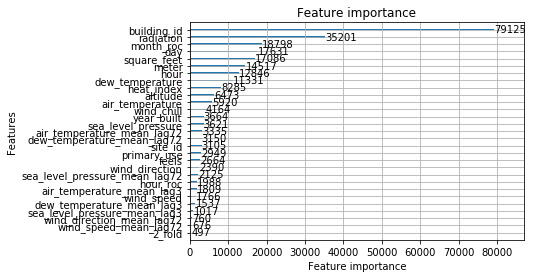

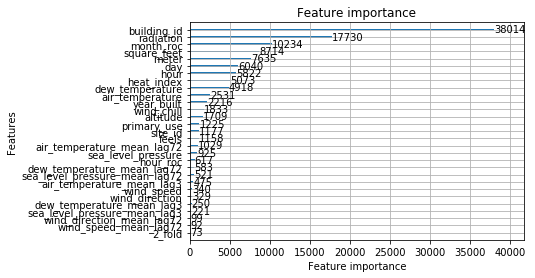

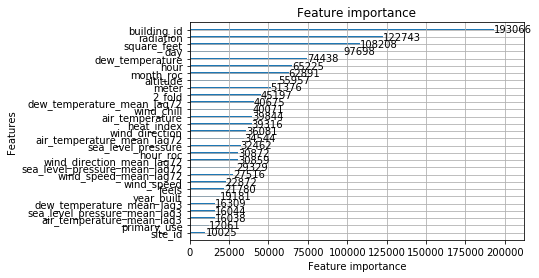

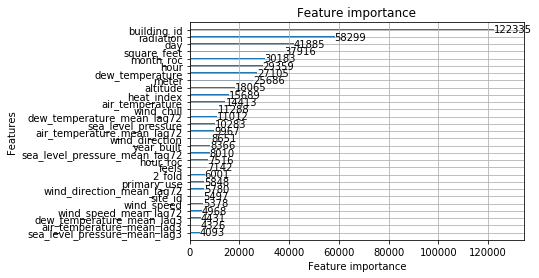

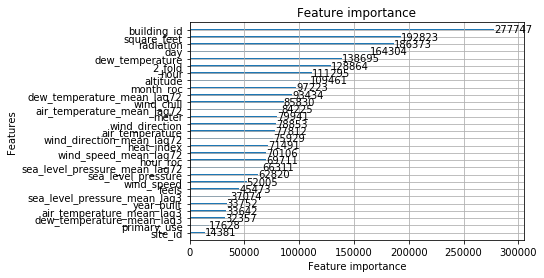

In [20]:
for model in models:
    lgb.plot_importance(model)
    plt.show()

#### 'is_holiday' and 'solar_spec' are consistantly on the bottom for each fold; hence, we will drop them, then predict using our test data.

In [ ]:
# X_train.drop(['is_holiday','solar_spec'], axis=1, inplace=True)
# test.drop(['is_holiday','solar_spec'], axis=1, inplace=True)

#### Dumping and pickling each model to save memory

In [3]:
import pickle

In [19]:
for model in models:
    pickle.dump(model, open("mod"+str(models.index(model))+".pickle.dat", "wb"))

In [4]:
mod0 = pickle.load(open("mod0.pickle.dat", "rb"))
mod1 = pickle.load(open("mod1.pickle.dat", "rb"))
mod2 = pickle.load(open("mod2.pickle.dat", "rb"))
mod3 = pickle.load(open("mod3.pickle.dat", "rb"))
mod4 = pickle.load(open("mod4.pickle.dat", "rb"))

In [5]:
models = [mod0,mod1,mod2,mod3,mod4]
models

### 5-Stratified Prediction

In [6]:
test = pd.read_pickle('test_mod2.pkl')
test.shape
gc.collect()

11

In [7]:
test.drop('dew_temperature_mean_lag3', axis=1, inplace=True)

In [6]:
# X_train.drop(['cloud_coverage','floor_count'], axis=1, inplace=True)
# test.drop(['cloud_coverage','floor_count'], axis=1, inplace=True)

In [8]:
results = []
for model in models:
    if  results == []:
        results = np.expm1(model.predict(test, num_iteration=model.best_iteration)) / len(models)
    else:
        results += np.expm1(model.predict(test, num_iteration=model.best_iteration)) / len(models)
    del model
    gc.collect()

In [10]:
results_df = pd.DataFrame({"row_id": range(0,len(test)), "meter_reading": np.clip(results, 0, a_max=None)})
# del results
gc.collect()
results_df.head()

,row_id,meter_reading
0,0,133.952234
1,1,27.905942
2,2,8.312961
3,3,239.048712
4,4,910.702906


In [11]:
results_df.to_csv("submission.csv", index=False)